In [1]:
import numpy as np
import datetime

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import astropy.units as u
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table, join
from astropy.io import fits
from astropy.visualization.wcsaxes.frame import EllipticalFrame

from photutils import CircularAperture

from skycam_utils.astrometry import update_altaz
from skycam_utils.photometry import load_skycam_catalog
from skycam_utils.fit_wcs import wcs_zea, wcs_refine_zea
from skycam_utils.fisheye_map import Fisheye, distortion_mapper, distortion_mapper_looper

Load the curated skycam catalog that contains photometry, names, positions, and other info for naked eye stars into `skycat`. Then load the catalog for the calibration image into `srccat`. This catalog is created using `photutils` to find sources and measure their properties. For the calibration image, the sources will need to be hand-labeled so they can be cross-referenced with `skycat`. Once an initial WCS is built from this, it should be possible to make refined or updated WCS's from that without having to do the hand-labeling step. The `id` column created by `photutils` needs to be renamed to `Star Name` to match the name used in `skycat`.

In [2]:
skycat = load_skycam_catalog()
srccat = Table.read("sources.csv")
srccat.rename_column('id', 'Star Name')
srccat

Star Name,xcentroid,ycentroid,source_sum,background_mean,obs_mag
str13,float64,float64,float64,str4,float64
Vega,399.03767642421195,300.6804533772003,2137.4321798860556,None,-8.324730858946696
Altair,388.38295217004537,188.06027982311235,1358.8854040391013,None,-7.832957084634927
Mirach,166.71669791620616,278.45856434214426,1274.5681747132821,None,-7.763407675444815
Fomalhaut,254.0523193094346,65.48054718915029,1235.683828727706,None,-7.729768407860634
Alpheratz,195.01251790349346,243.4747047148541,1005.5753814265595,None,-7.506036580943276
Scheat,237.18260819428508,231.82046172313198,973.0701259985354,None,-7.470360348966787
Rasalgethi,478.70058144813703,262.11132858125814,940.5713621612293,None,-7.433479378815152
Eltanin,388.891479324866,346.3863336212628,937.6096116883733,None,-7.4300551269160175
Tsih,215.00136088601428,348.52342549223863,918.101929415987,None,-7.407227250185818


This is an example of a clear, dark image and its header. The `UT` is needed to calculate the Alt/Az for the catalog stars.

In [5]:
hdul = fits.open("data_0000935.fits.gz")
im = hdul[0].data
hdr = hdul[0].header
hdr

SIMPLE  =                    T / Created with PDL (http://pdl.perl.org)         
BITPIX  =                    8                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  640                                                  
NAXIS2  =                  480                                                  
BUNIT   = 'Data Value'                                                          
DATAMAX =         2.550000E+02                                                  
DATAMIN =         0.000000E+00                                                  
GAIN    =                  106                                                  
FRAME   = '256 Frames'                                                          
DATE    = '2011-10-21'                                                          
UT      = '03:00:54'                                                            
LST     = '21:34:13.946'    

I don't understand why people don't simply use ISO format for time strings. It is so much easier and universally understood. So we parse what we have into `datetime` and make a `Time` object from that.

In [6]:
#dt = datetime.datetime.strptime(hdr['UT'], "%a %b %d %H:%M:%S %Y")
tobs = Time(f"{hdr['DATE']}T{hdr['UT']}", scale='utc')
tobs

<Time object: scale='utc' format='isot' value=2011-10-21T03:00:54.000>

Use the `update_altaz` function to update the `Alt` and `Az` columns in `skycat` based on `tobs`. The columns will be added if they don't exist.

In [7]:
skycat = update_altaz(skycat, time=tobs)

Join the catalogs based on `Star Name` and keep the most relevant columns.

In [8]:
joint = join(skycat, srccat, keys='Star Name', join_type='inner')
joint.keep_columns(['Star Name', 'Identity', 'xcentroid', 'ycentroid', 'Magnitude', 'obs_mag', 'background_mean', 'RA', 'Dec', 'Alt', 'Az'])
joint.sort('Magnitude')
joint

Star Name,Identity,Magnitude,RA,Dec,Alt,Az,xcentroid,ycentroid,background_mean,obs_mag
,,,,,deg,deg,,,,
str17,str25,float64,float64,float64,float64,float64,float64,float64,str4,float64
Vega,Alpha Lyrae,0.03,279.2347347,38.7836889,53.54900578413234,293.8059445923008,399.03767642421195,300.6804533772003,None,-8.324730858946696
Altair,Alpha Aquilae,0.77,297.69575,8.8683333,57.00075723486197,231.92411591181727,388.38295217004537,188.06027982311235,None,-7.832957084634927
Fomalhaut,Alpha Piscis Austrini,1.16,344.413,-29.6222167,25.580796087748976,159.75986085566538,254.0523193094346,65.48054718915029,None,-7.729768407860634
Mirfak,Alpha Persei,1.79,51.0807086,49.8611792,25.048765534437518,45.26774328961325,154.2199323609001,361.24301555582,None,-7.265656950795602
Hamal,Alpha Arietis,2.0,31.7933572,23.4624175,29.784297945411048,79.21851263058284,123.88963736931366,259.51740927693817,None,-7.047282157262539
Polaris,Alpha Ursae Minoris,2.02,37.953,89.2641667,31.82306191283718,0.7905662321570538,279.6033359719988,414.0734560459411,None,-7.08226191552492
Alpheratz,Alpha Andromedae,2.06,2.097,29.09055,56.707648606399,84.08056114695658,195.01251790349346,243.4747047148541,None,-7.506036580943276
Mirach,Beta Andromedae,2.06,17.4330161,35.6205578,45.413695910917966,69.49506506528509,166.71669791620616,278.45856434214426,None,-7.763407675444815


Do the WCS fit with a reasonable guess for initial parameters. 

In [15]:
fun = wcs_zea(joint['xcentroid'], joint['ycentroid'], joint['Alt'], joint['Az'], crpix1=301, crpix2=243, a_order=2, b_order=2)
init = np.array([301, 243, 1, 1, 0.4, 0.03, 0.03, 0.4])
sip_init = np.zeros(18)
#x0 = np.append(init, sip_init)
x0 = init
fit_result = minimize(fun, x0)


A little confusing to use RA and DEC when we're actually doing Alt and Az. This fit seems to work, though, and the numbers look reasonable.

In [16]:
wcs_initial = fun.return_wcs(fit_result.x)
wcs_initial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 301.01247386433676  244.8372266488114  
PC1_1 PC1_2  : 0.30692502166766283  0.03218417727070501  
PC2_1 PC2_2  : -0.028989966971608418  0.2759842304228659  
CDELT : 1.0393073177697563  1.1554538273126786  
NAXIS : 0  0

The residuals look pretty good, too. The only significant outliers are the ones at the very edge of the field of view. 

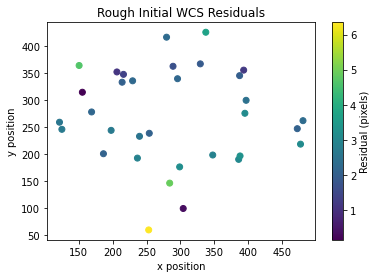

In [17]:
fit_x, fit_y = wcs_initial.all_world2pix(joint['Az'], joint['Alt'], 0)
resid_d = ((fit_x-joint['xcentroid'])**2+(fit_y-joint['ycentroid'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')
plt.show()

In [18]:
resid_d[resid_d < 10].mean()

2.523696414652891

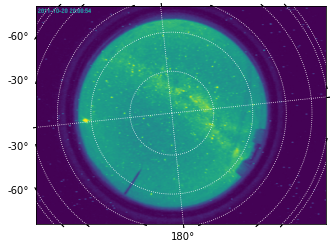

In [19]:
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
plt.show()

In [23]:
ax.coords

<CoordinatesMap with 2 world coordinates:

  index           aliases              type   unit wrap format_unit visible
  ----- --------------------------- --------- ---- ---- ----------- -------
      0   pos.eq.ra ra---zea-sip ra longitude  deg  360         deg     yes
      1 pos.eq.dec dec--zea-sip dec  latitude  deg None         deg     yes

>

In [20]:
wcs_fits = wcs_initial.to_fits()
wcs_fits.writeto("wcs_2011.fits")

In [44]:
test = WCS("wcs.fits")

In [21]:
joint.write("astrometry.csv")

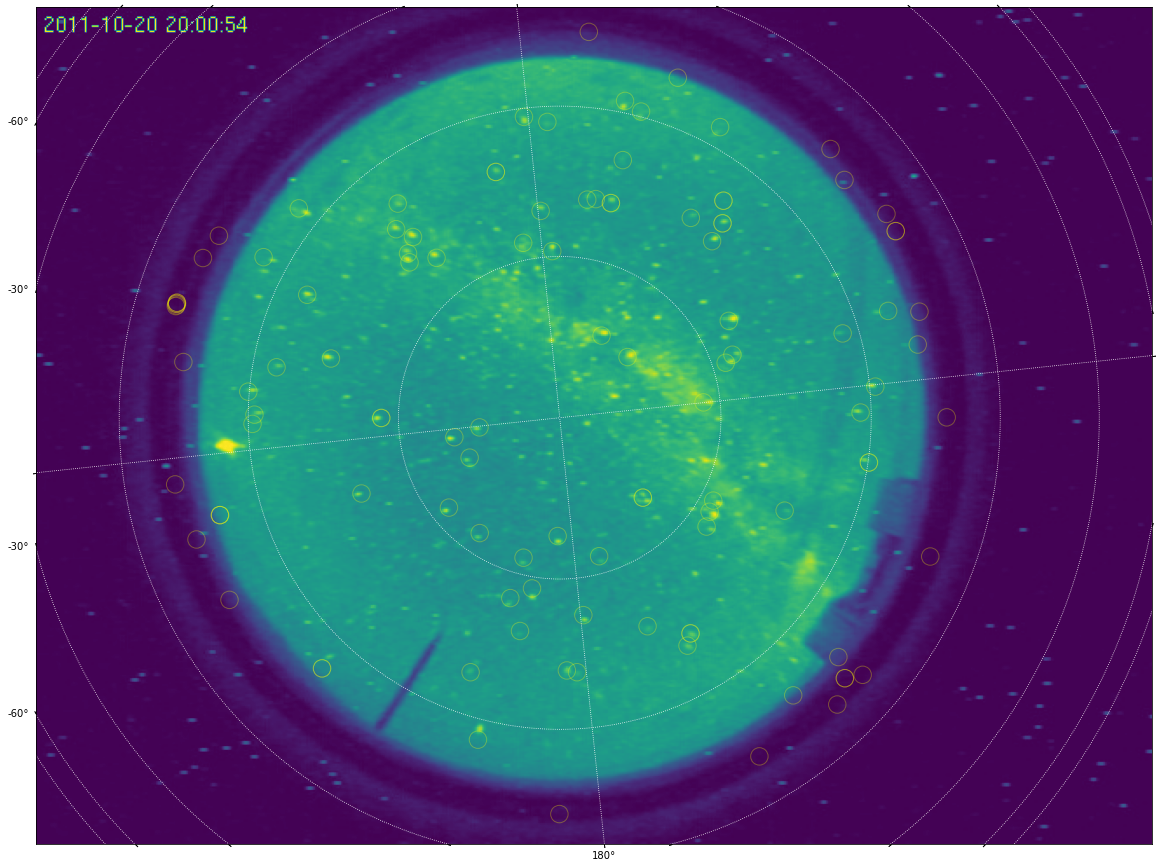

In [22]:
plt.figure(figsize=[20,20])
skycat = skycat[skycat['Alt'] > 10.0]
pred_x, pred_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
aps = CircularAperture((joint['xcentroid'], joint['ycentroid']), r=5.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
#aps.plot(color='red', lw=1.5, alpha=0.5)
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
plt.show()